This Model uses a Random Forest at attempt to look ahead 10 minutes (rather than 1 Mile)

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
auth.authenticate_user()

In [4]:
# !gcloud config set project {'hackathon-352519'}

In [5]:
#filename = "train-data_all-train-events.zip"
filename = "train-data-2022062020220626.zip"

In [6]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
\ [1 files][192.2 MiB/192.2 MiB]                                                
Operation completed over 1 objects/192.2 MiB.                                    


In [7]:
trains = {}
i = 1
# prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # Make sure there is at least ten minutes of actuals
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 4): 
                    # trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    # prevLoco = currentLoco
                            

1000   22:05:20
2000   22:05:30
3000   22:05:35
4000   22:05:41
5000   22:05:47
6000   22:05:52
7000   22:05:57
8000   22:06:03
9000   22:06:08
10000   22:06:14
11000   22:06:19
12000   22:06:25
13000   22:06:29
14000   22:06:35
15000   22:06:40
16000   22:06:46
17000   22:06:50
18000   22:06:56
19000   22:07:01
20000   22:07:08
21000   22:07:12
22000   22:07:21
23000   22:07:25
24000   22:07:29
25000   22:07:36
26000   22:07:40
27000   22:07:44
28000   22:07:52
29000   22:07:56
30000   22:08:00
31000   22:08:04


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31810 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            31810 non-null  object 
 1   positionHistoryList                                            31810 non-null  object 
 2   locomotiveList                                                 31810 non-null  object 
 3   subdivisionList                                                31810 non-null  object 
 4   trainEstimatedPositionList                                     31810 non-null  object 
 5   trainActualPositionList                                        31810 non-null  object 
 6   trainId.trainSCAC                                              31810 non-null  object 
 7   trainId.trainSection                                          

In [11]:
dfTrainsLearn = dfTrainsAll

In [12]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)
# print(dfTrainsLearn['trailingTonnage'].unique())

In [13]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

In [14]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

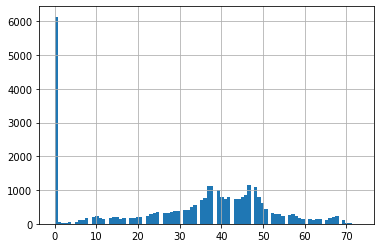

In [15]:
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

In [16]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

In [17]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
print(dfTrainsLearn['symbolType'].unique())

['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'W' 'R']


In [18]:
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [19]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45.]


In [20]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [21]:
# routeLoca = dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].str.len() > 0]['aotuTrainData.routeLocationList']
# route = routeLoca.iloc[0]
# print(route)
# jsroute = pd.json_normalize(route)
# jsroute

In [22]:
# dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]
# dfTrainsLearn[dfTrainsLearn['aotuTrainData.routeLocationList'].apply(lambda x: isinstance(x, float))]['aotuTrainData.routeLocationList']

In [23]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [24]:
dfTrainsLearn['workLocations'].unique()

array([None, '225.10', '202.20', '202.20,219.70', '250.50,202.20', '258.40,202.20', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '202.20,314.52', '202.20,214.50,225.10,290.80,304.10',
       '214.50,225.10,290.80,304.10,202.20', '321.50,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '258.40,207.60,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,258.40,321.50,219.70', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [25]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [26]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [27]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [28]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-25T22:03:36Z,15,106,MAIN,765.54820
1,2022-06-25T22:05:36Z,19,106,WEST MAIN,766.13635
2,2022-06-25T22:07:36Z,10,106,WEST MAIN,766.48220
3,2022-06-25T22:09:36Z,0,106,WEST MAIN,766.82220
4,2022-06-25T22:11:36Z,0,106,WEST MAIN,766.82220
5,2022-06-25T22:13:36Z,0,106,WEST MAIN,766.82220
6,2022-06-25T22:15:36Z,0,106,WEST MAIN,766.82220
7,2022-06-25T22:17:36Z,0,106,WEST MAIN,766.82220


In [29]:
dfTrainsLearn.iloc[1]['lastReportedPosition.speedMPH']

10

In [30]:
def findNextSpeed(trainsEntry, actualsEntry):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  return (abs(actualsEntry.iloc[4]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))

In [31]:
findNextSpeed(dfTrainsLearn.iloc[101], dfTrainsLearnActuals.iloc[101])

9

In [32]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['ptcLeadLocomotiveId'])
dfTrainsLearn

,ptcLeadLocomotiveId,positionHistoryList,locomotiveList,subdivisionList,...,mpIncr,symbolType,workLocations,locomotiveCount
0,AMTK206,"[{'positionTime': '2022-06-25T22:00:53Z', 'speedMPH': 9, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'TO_S_UP_MAINLINE', 'milepost': {'milepostNumber': 764.8683}}}, {'positionTime': '2022-06-25T21:59:40Z', 'speedMPH': 15, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT', 'milepost': {'milepostNumber': 276.7377}}}, {'positionTime': '2022-06-25T21:59:09Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT', 'milepost': {'milepostNumber': 276.6104}}}, {'positionTime': '2022-06-25T21:54:54Z', 'speedMPH': 30, 'milepostLocation': {'subdivisionId'...",[],"[{'subdivisionId': 595}, {'subdivisionId': 605}, {'subdivisionId': 538}, {'subdivisionId': 461}, {'subdivisionId': 599}, {'subdivisionId': 477}]",...,True,NaN,None,0
1,AMTK206,"[{'positionTime': '2022-06-25T22:01:36Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.987}}}, {'positionTime': '2022-06-25T22:00:53Z', 'speedMPH': 9, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'TO_S_UP_MAINLINE', 'milepost': {'milepostNumber': 764.8683}}}, {'positionTime': '2022-06-25T21:59:40Z', 'speedMPH': 15, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT', 'milepost': {'milepostNumber': 276.7377}}}, {'positionTime': '2022-06-25T21:59:09Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId...",[],"[{'subdivisionId': 595}, {'subdivisionId': 605}, {'subdivisionId': 538}, {'subdivisionId': 461}, {'subdivisionId': 599}]",...,True,NaN,None,0
2,AMTK206,"[{'positionTime': '2022-06-25T22:01:39Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.9957}}}, {'positionTime': '2022-06-25T22:01:36Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.987}}}, {'positionTime': '2022-06-25T22:00:53Z', 'speedMPH': 9, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'TO_S_UP_MAINLINE', 'milepost': {'milepostNumber': 764.8683}}}, {'positionTime': '2022-06-25T21:59:40Z', 'speedMPH': 15, 'milepostLocation': {'subdivision...",[],"[{'subdivisionId': 595}, {'subdivisionId': 605}, {'subdivisionId': 538}, {'subdivisionId': 461}, {'subdivisionId': 599}]",...,True,NaN,None,0
3,AMTK206,"[{'positionTime': '2022-06-25T22:04:59Z', 'speedMPH': 19, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 765.9402}}}, {'positionTime': '2022-06-25T22:01:39Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.9957}}}, {'positionTime': '2022-06-25T22:01:36Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.987}}}, {'positionTime': '2022-06-25T22:00:53Z', 'speedMPH': 9, 'milepostLocation': {'subdivisionId': 106, 't...",[],"[{'subdivisionId': 595}, {'subdivisionId': 605}, {'subdivisionId': 538}, {'subdivisionId': 461}, {'subdivisionId': 599}]",...,True,NaN,None,0
4,AMTK206,"[{'positionTime': '2022-06-25T22:05:34Z', 'speedMPH': 19, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.1306}}}, {'positionTime': '2022-06-25T22:04:59Z', 'speedMPH': 19, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 765.9402}}}, {'positionTime': '2022-06-25T22:01:39Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MAIN', 'milepost': {'milepostNumber': 764.9957}}}, {'positionTime': '2022-06-25T22:01:36Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': ...",[],"[{'subdivisionId': 595}, {'subdivisionId': 605}, {'subdivisionId': 538}, {'subdivisionId': 461}, {'subdivisionId': 599}]",...,True,NaN,None,0
...,...,...,...,...,...,...,...,...,...
31805,UP9101,"[{'posit

In [33]:
dfTrainsLearn['nextSpeed'] = dfTrainsLearn['lastReportedPosition.speedMPH']
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  actualsEntry = dfTrainsLearnActuals.iloc[i]
  nextSpeed = findNextSpeed(trainsEntry, actualsEntry)
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [34]:
# dfTrainsLearn = dfTrainsLearn.drop(['hour'], axis=1)
dfTrainsLearn['nextSpeed'].unique()

array([ -9, -10, -19,  -1,  -3,  -4,   0,   1,  -2,   4,   5, -14,  -8,  -6,   2,  13,  -5,   3,  14,  19,  17,  16, -20, -25, -30, -27,  18,  30,  33,  31,  21, -11,   9,  10, -15, -31, -34, -28,
       -24, -12,  15,   7,   6,   8,  -7, -18, -13, -16, -22, -33, -35, -17,  25,  35,  26, -36, -48, -49, -43,  20,  11,  23, -29,  12, -23,  22,  38,  29,  28,  24,  27, -32, -26,  37, -39,  34,
        36, -46, -45,  46,  44, -21,  40, -42,  43,  45, -55, -58, -40, -51, -38, -47, -37, -50, -63, -61, -54,  53,  52,  42,  39,  32,  48, -44, -41,  41,  61,  49, -57, -62, -53,  54,  57,  58,
        50, -52, -59,  47, -68, -65,  65,  51,  56, -64, -66, -67, -60, -56,  64,  69,  59])

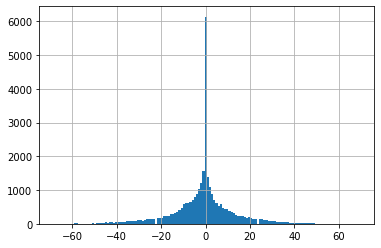

In [35]:
dfTrainsLearn['nextSpeed'].hist(bins=140)

Drop some values we are not using at the moment not needed

In [37]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            # 'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            # 'lastReportedPosition.nextSignalState.previousSignalState', 
                                            # 'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [38]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,AMTK206,UP,,AMT1,...,False,False,False,1.656194e+09
1,AMTK206,UP,,AMT1,...,False,False,False,1.656194e+09
2,AMTK206,UP,,AMT1,...,False,False,False,1.656194e+09
3,AMTK206,UP,,AMT1,...,False,False,False,1.656195e+09
4,AMTK206,UP,,AMT1,...,False,False,False,1.656195e+09
...,...,...,...,...,...,...,...,...,...
31805,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
31806,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
31807,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
31808,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09


In [39]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(31810, 47)
(31810,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31810 entries, 0 to 31809
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            31810 non-null  object        
 1   trainId.trainSCAC                                              31810 non-null  object        
 2   trainId.trainSection                                           31810 non-null  object        
 3   trainId.trainSymbol                                            31810 non-null  object        
 4   trainId.trainDate                                              31810 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  31810 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            31810 non-

# Use Decision Tree to predict speed in 1 mile

In [40]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [41]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
171    3951
172    4255
173    4175
174    5299
175    4704
176    4348
177    4593
178     485
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [42]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 176 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [43]:
dep_var = 'nextSpeed'

In [44]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [45]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [46]:
len(to.train),len(to.valid)

(22384, 9426)

In [47]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,aotuTrainData.eventCode,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
5,BNSF3185,UP,,QNSIJJ,2022-06-21,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,10,766.930603,2.0,12.0,2.0,3.0,125003368.0,630310.0,6916630.0,16010.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,23,3,174,1.655972e+09,-1
9,BNSF3907,UP,,QIJDYJ,2022-06-21,106,TO_S_UP_MAINLINE,True,#na#,#na#,2022,6,False,False,False,False,False,False,6,764.868286,2.0,12.0,2.0,3.0,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,23,3,174,1.655957e+09,0
10,BNSF3907,UP,,QIJDYJ,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,6,764.930298,2.0,12.0,2.0,3.0,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,23,3,174,1.655957e+09,0
11,BNSF3907,UP,,QIJDYJ,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,5,764.986816,2.0,12.0,2.0,3.0,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,23,3,174,1.655957e+09,1
12,BNSF3907,UP,,QIJDYJ,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,6,765.284424,2.0,12.0,2.0,3.0,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,765,0,25,23,3,174,1.655957e+09,-1
13,BNSF3907,UP,,QIJDYJ,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,6,765.684998,2.0,12.0,2.0,3.0,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,765,0,25,23,3,174,1.655957e+09,-2
14,BNSF3935,UP,,QIJNSJ,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,9,764.987183,2.0,12.0,2.0,3.0,0.0,0.0,8475000.0,17720.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655893e+09,4
15,BNSF4554,UP,,QIJBLJ,2022-06-19,106,TO_S_UP_MAINLINE,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.870178,2.0,12.0,2.0,3.0,175060000.0,759960.0,8400000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655701e+09,4
16,BNSF4554,UP,,QIJBLJ,2022-06-19,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,9,764.988525,2.0,12.0,2.0,3.0,175060000.0,759960.0,8400000.0,17560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655701e+09,5
17,BNSF5040,UP,,QDYIJJ,2022-06-22,106,EAST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,14,766.864807,2.0,12.0,2.0,3.0,0.0,0.0,8520000.0,17560.0,65535.0,0.0,0.0,0

In [48]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [49]:
to = fastai.load_pickle('/tmp/to.pkl')

In [50]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [51]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

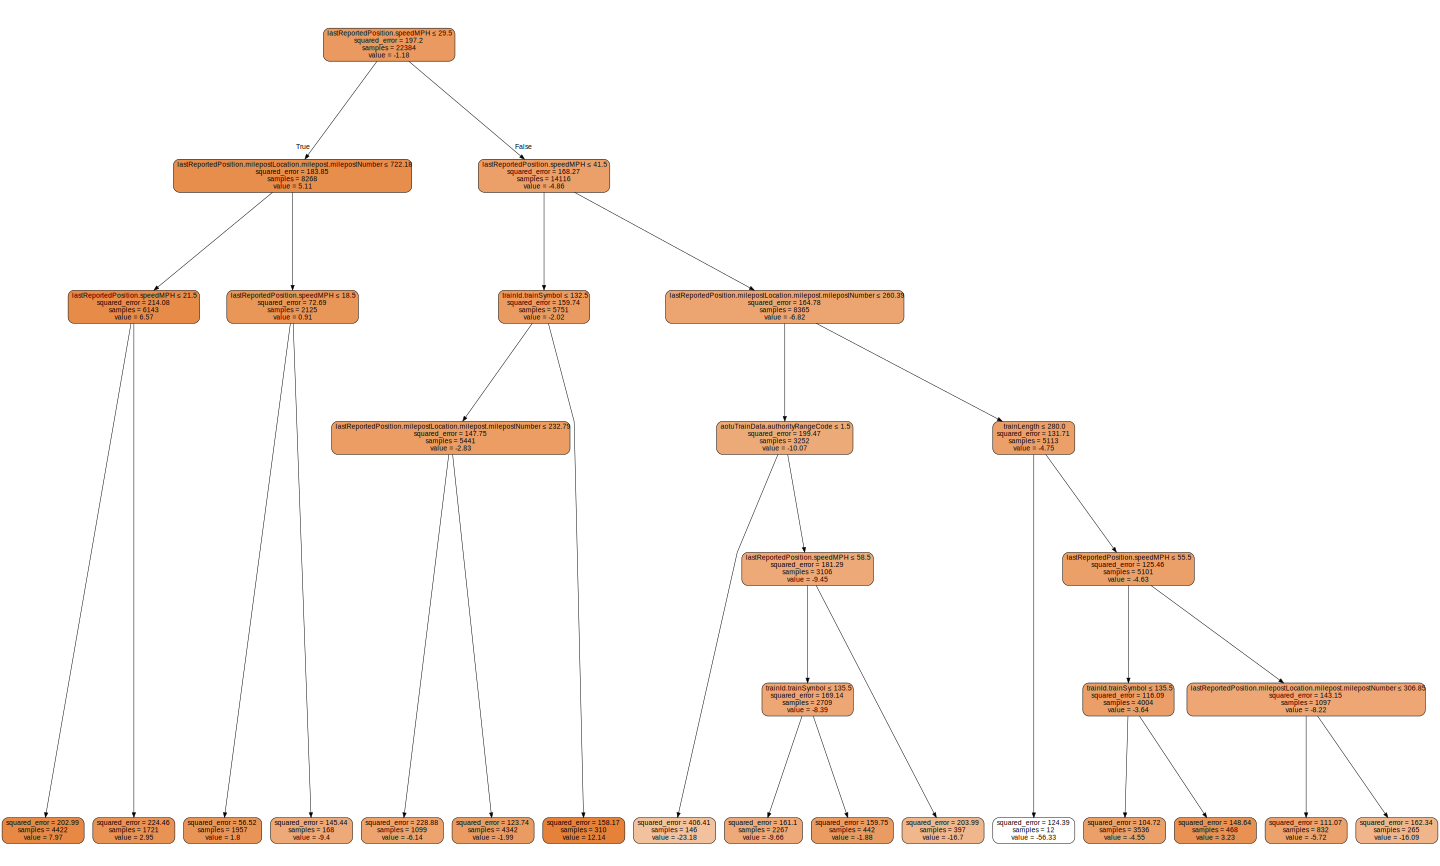

In [52]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [53]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [54]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [55]:
m_rmse(m, xs, y)

7.989693

In [56]:
m_rmse(m, valid_xs, valid_y)

15.300205

In [57]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [58]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
18,lastReportedPosition.speedMPH,0.271591
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.209222
45,lastReportedPosition.positionTimeElapsed,0.134429
3,trainId.trainSymbol,0.070918
39,milepost,0.033342
37,trainLength,0.026939
0,ptcLeadLocomotiveId,0.026093
7,mpIncr,0.024328
26,aotuTrainData.totalLocomotiveWeight,0.022686
38,trailingTonnage,0.019777


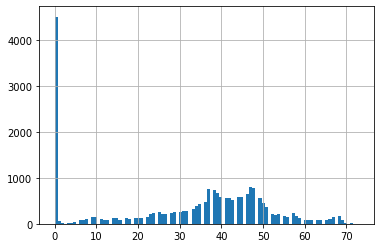

In [79]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=100)


This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [95]:
def randomForest(xs, y, n_estimators=50, max_samples=18000,
       max_features=0.5, min_samples_leaf=10, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [96]:
m = randomForest(xs, y);

In [97]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(8.27119, 11.633249)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [90]:
r_mse(preds.mean(0), valid_y)

11.816036

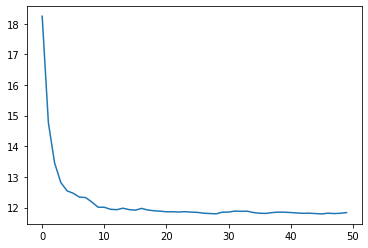

In [91]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [66]:
r_mse(m.oob_prediction_, y)

9.595041

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [68]:
preds.shape

(50, 9426)

In [69]:
preds_std = preds.std(0)

In [70]:
print(preds.mean(0)[:15])
print(valid_y[:15])

[ 7.84578644  7.81087374  7.81087374 -1.04908297 -1.36753824  7.11876479  7.69257431  7.4135267   6.41965512 -1.75513647 -1.38574698  6.84568038 -1.29038167 -1.31651804 -0.3697417 ]
0      -9
1     -10
2     -10
3     -19
4     -19
6      -3
7      -3
8      -4
108     1
109     2
110     3
160     6
161     6
162     5
163     4
Name: nextSpeed, dtype: int8


# FEATURE Importance

In [71]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
18,lastReportedPosition.speedMPH,0.264440
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.171789
39,milepost,0.092256
45,lastReportedPosition.positionTimeElapsed,0.092124
3,trainId.trainSymbol,0.048282
0,ptcLeadLocomotiveId,0.029727
38,trailingTonnage,0.027790
37,trainLength,0.027553
24,aotuTrainData.totalCarWeight,0.024012
26,aotuTrainData.totalLocomotiveWeight,0.023316


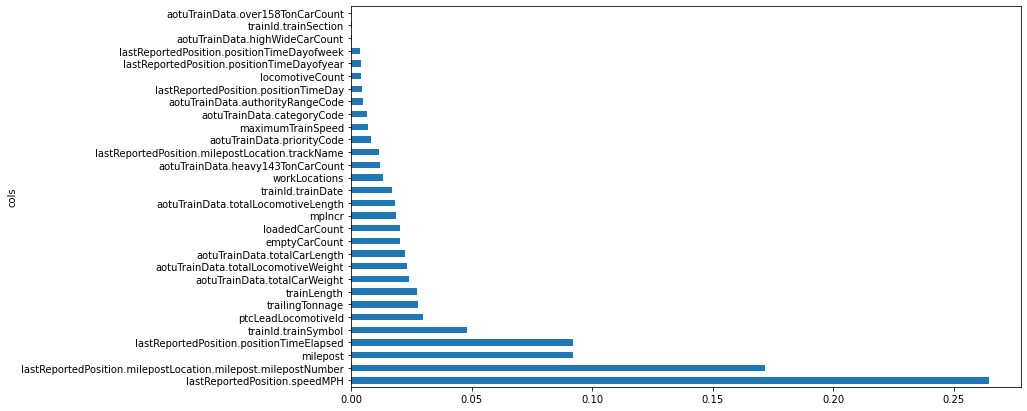

In [72]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [73]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

29

In [74]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [75]:
m = randomForest(xs_imp, y)

In [76]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(8.34641, 11.913327)

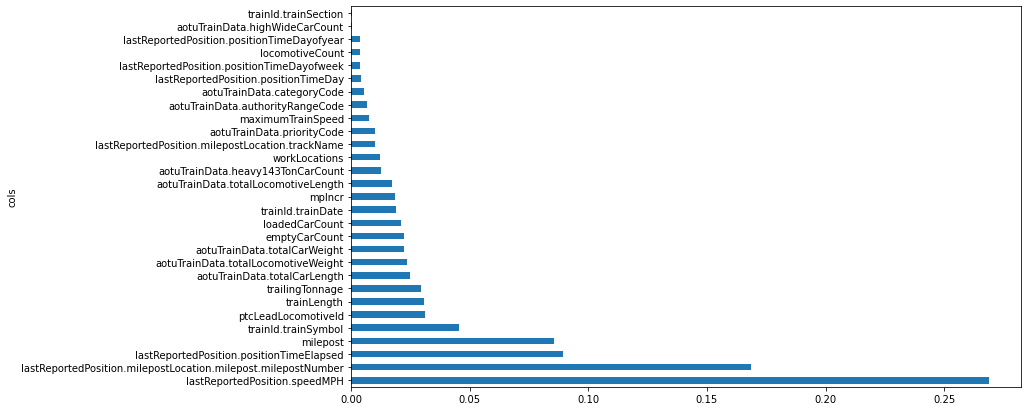

In [77]:
plot_fi(rf_feat_importance(m, xs_imp));

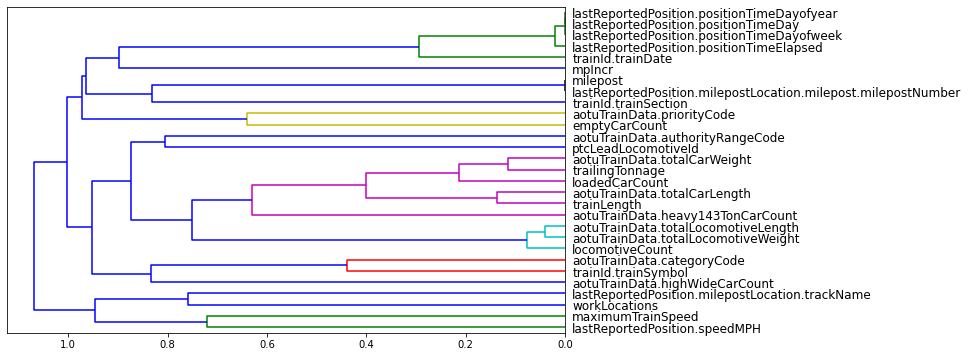

In [78]:
fastai.cluster_columns(xs_imp)